In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
try:
    from xgboost import XGBClassifier
    has_xgb = True
except Exception:
    has_xgb = False


In [15]:
# 3) Project title and objective (print)
PROJECT_TITLE = "Heart Failure Prediction Dataset"
print("Project:", PROJECT_TITLE)
print("Goal: Predict heart failure / presence of heart disease from patient features.")

Project: Heart Failure Prediction Dataset
Goal: Predict heart failure / presence of heart disease from patient features.


In [21]:
# ====== Cell 4: Load Data via Uploader (for Colab/Cloud) ======
import pandas as pd
from google.colab import files

print("Upload your heart.csv file (a file selector dialog will pop up).")
uploaded = files.upload() # Choose heart.csv from your machine

# The file is now in the current working directory, so we can read it directly by name.
# Note: If you uploaded a file with a different name, change 'heart.csv' here.
df = pd.read_csv('heart.csv')
print("\nLoaded dataset shape:", df.shape)
print('\nColumns:', df.columns.tolist())

df.head()

Upload your heart.csv file (a file selector dialog will pop up).


Saving heart.csv to heart (2).csv

Loaded dataset shape: (918, 12)

Columns: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [22]:
if 'heart.csv' not in uploaded:
    print("WARNING: 'heart.csv' was not uploaded. Reading the first uploaded file.")
    df = pd.read_csv(list(uploaded.keys())[0])
else:
    df = pd.read_csv('heart.csv')

print('\nLoaded data shape:', df.shape)
print('\nColumns:', df.columns.tolist())
print('\nFirst 5 rows:')
print(df.head())


Loaded data shape: (918, 12)

Columns: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']

First 5 rows:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


--- BASIC INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None

Missing values:
 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0

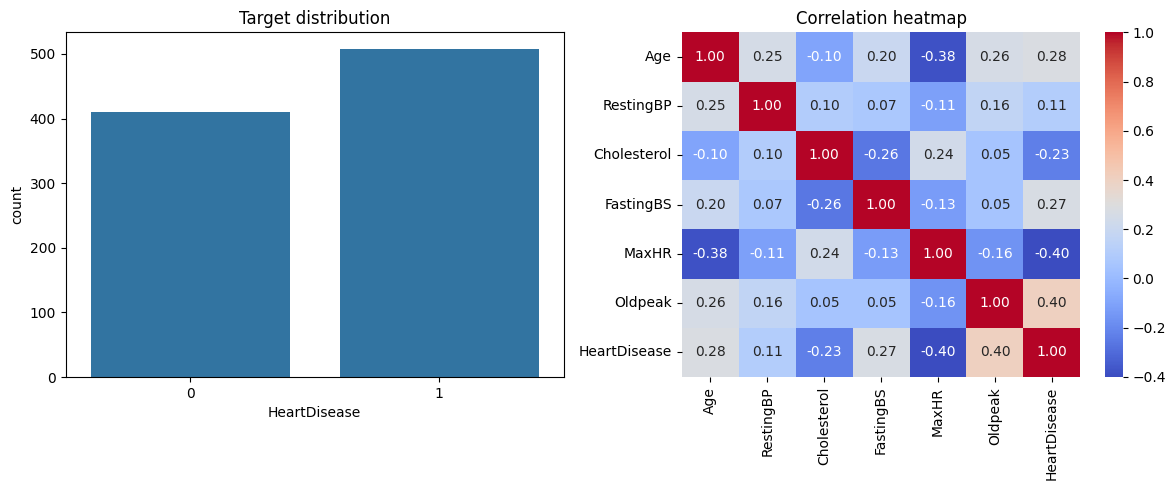

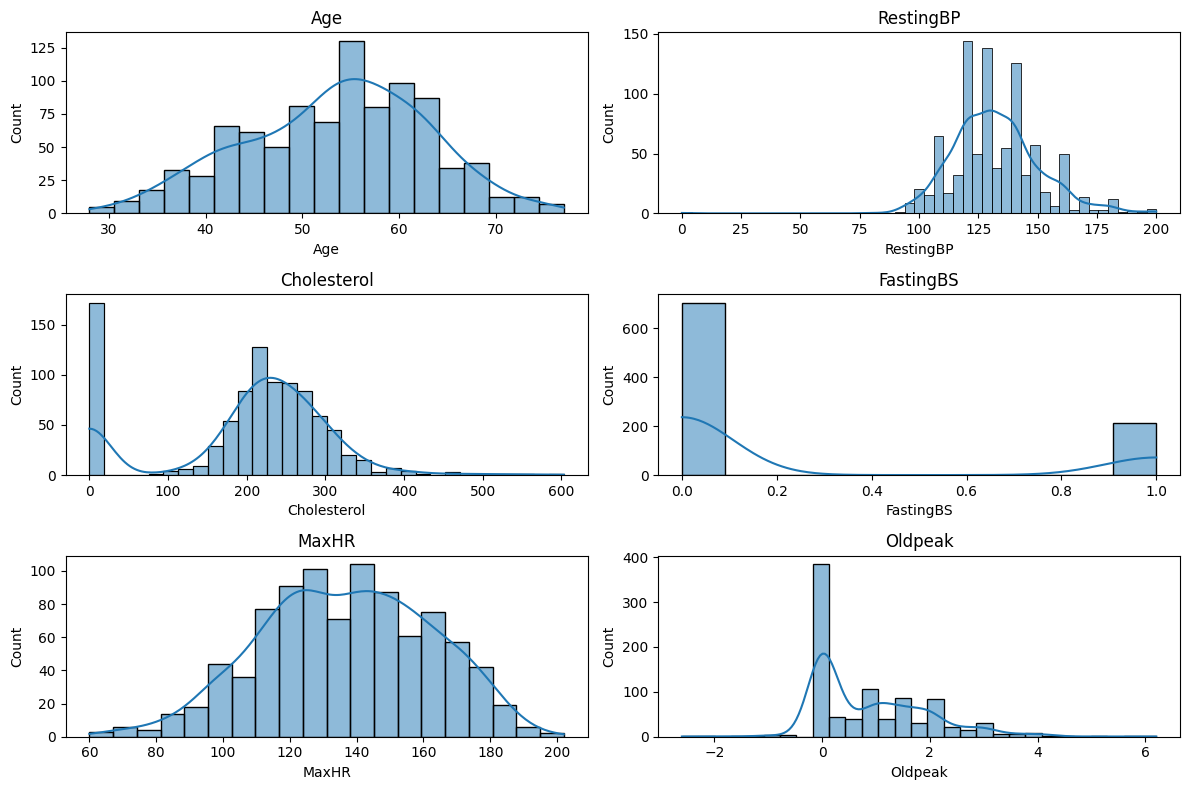

In [27]:
## 📊 4) Quick EDA
# ---

print('\n--- BASIC INFO ---')
print(df.info())
print('\nMissing values:\n', df.isnull().sum())
print('\nDescriptive statistics:')
print(df.describe().T)

# Visualizations (a few helpful charts)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# Assuming target is the last column for visualization before identification in cleaning
target_col_candidate = df.columns[-1]
sns.countplot(x=df[target_col_candidate])
plt.title('Target distribution')
plt.xlabel(target_col_candidate)

plt.subplot(1, 2, 2)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation heatmap')
plt.tight_layout()
plt.show()

# Show distributions of a few numeric features
plt.figure(figsize=(12, 8))
# Use up to 6 numeric columns for distribution plots
for i, col in enumerate(numeric_cols[:6], 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# ---

In [28]:
## ✨ 5) Data Cleaning & Quick Feature Engineering
# ---

df_clean = df.copy()

# Identify target column
target_col = None
for candidate in ['target','Target','heart_disease','HeartDisease','output','DEATH_EVENT','target_class']:
    if candidate in df_clean.columns:
        target_col = candidate
        break
if target_col is None:
    target_col = df_clean.columns[-1]
print('\nUsing target column:', target_col)

# Example feature: if 'age' present we can bucket it
if 'age' in df_clean.columns:
    df_clean['age_bin'] = pd.cut(df_clean['age'], bins=[0,30,45,60,120], labels=['<30','30-45','45-60','60+'])

# Convert obvious boolean-like columns to int
for c in df_clean.columns:
    if df_clean[c].dtype == 'bool':
        df_clean[c] = df_clean[c].astype(int)

# ---


Using target column: HeartDisease


In [31]:
## ⚙️ 6) Preprocessing: Define Pipeline and Split Data
# ---

X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

# Identify feature types
# Use original column names for the ColumnTransformer
X_temp = df_clean.drop(columns=[target_col])

numeric_features = X_temp.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Includes 'object' and 'category' (like the new 'age_bin' and typical categorical features)
cat_features = X_temp.select_dtypes(include=['object', 'category']).columns.tolist()

# Drop 'age' from the feature set if 'age_bin' was created, to avoid multicollinearity
if 'age' in X.columns and 'age_bin' in X.columns:
    if 'age' in numeric_features:
        numeric_features.remove('age')
    X = X.drop(columns=['age'])
    print("Dropped original 'age' to use binned 'age_bin'.")

print('\nNumeric features (to be scaled):', numeric_features)
print('Categorical features (to be OHE):', cat_features)

# Pipeline for Numeric Features: Impute median, then Scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for Categorical Features: Impute mode, then One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False makes it a dense array
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, cat_features)
    ],
    remainder='drop' # Drop any columns not specified
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('\nTrain shape (Original):', X_train.shape, 'Test shape (Original):', X_test.shape)

# Fit preprocessor and transform (creates numpy arrays)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print(f"Processed Train shape: {X_train_processed.shape}, Processed Test shape: {X_test_processed.shape}")


# ---


Numeric features (to be scaled): ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Categorical features (to be OHE): ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

Train shape (Original): (734, 11) Test shape (Original): (184, 11)
Processed Train shape: (734, 20), Processed Test shape: (184, 20)


In [32]:
## 🧠 7) Model Training and Comparison
# ---

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42)
}
if has_xgb:
    models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

results = {}
print('\n--- TRAINING RESULTS ---')
for name, model in models.items():
    model.fit(X_train_processed, y_train)
    preds = model.predict(X_test_processed)
    acc = accuracy_score(y_test, preds)
    roc = None
    try:
        # Use processed data for prediction
        probs = model.predict_proba(X_test_processed)[:,1]
        roc = roc_auc_score(y_test, probs)
    except Exception:
        pass
    print(f"{name}: Accuracy={acc:.4f}", end='')
    if roc is not None:
        print(f", ROC-AUC={roc:.4f}")
    else:
        print('')
    results[name] = {'model': model, 'accuracy': acc, 'roc_auc': roc, 'preds': preds}

# ---


--- TRAINING RESULTS ---
LogisticRegression: Accuracy=0.8859, ROC-AUC=0.9299
DecisionTree: Accuracy=0.7935, ROC-AUC=0.7910
RandomForest: Accuracy=0.9022, ROC-AUC=0.9331
KNN: Accuracy=0.8967, ROC-AUC=0.9431
SVM: Accuracy=0.8967, ROC-AUC=0.9494
XGBoost: Accuracy=0.8750, ROC-AUC=0.9291



Model comparison:
                Model  Accuracy   ROC_AUC
2        RandomForest  0.902174  0.933106
3                 KNN  0.896739  0.943089
4                 SVM  0.896739  0.949426
0  LogisticRegression  0.885870  0.929938
5             XGBoost  0.875000  0.929101
1        DecisionTree  0.793478  0.791009


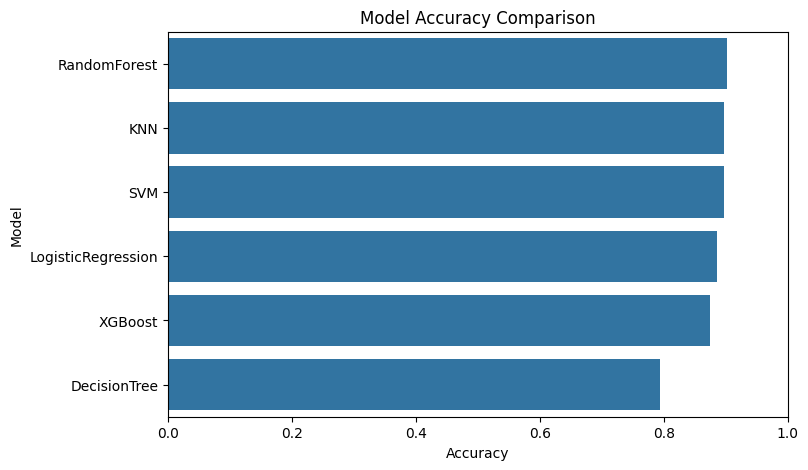


Best Model: RandomForest

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        82
           1       0.90      0.93      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



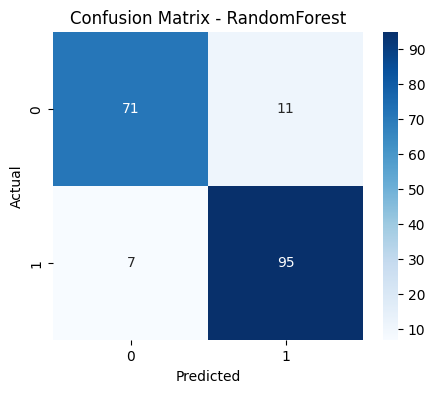

In [33]:
## 📈 8) Evaluation and Comparison
# ---

comparison = pd.DataFrame([{'Model': k, 'Accuracy': v['accuracy'], 'ROC_AUC': v['roc_auc']} for k,v in results.items()]).sort_values('Accuracy', ascending=False)
print('\nModel comparison:')
print(comparison)

plt.figure(figsize=(8, 5))
sns.barplot(data=comparison, x='Accuracy', y='Model')
plt.xlim(0,1)
plt.title('Model Accuracy Comparison')
plt.show()

# Detailed evaluation for best model
best_name = comparison.iloc[0]['Model']
best = results[best_name]['model']
print('\nBest Model:', best_name)

best_preds = results[best_name]['preds']
print('\nClassification Report:')
print(classification_report(y_test, best_preds))

cm = confusion_matrix(y_test, best_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ---


--- CROSS-VALIDATION ---
RandomForest CV accuracy: mean=0.8311 std=0.0391
KNN CV accuracy: mean=0.8365 std=0.0438
SVM CV accuracy: mean=0.8322 std=0.0433


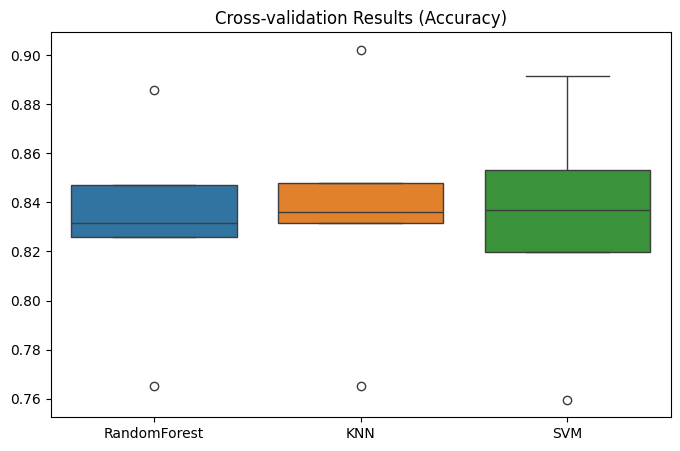

In [34]:
## 🔎 9) Cross-Validation of Top Models
# ---

top3 = comparison.head(3)['Model'].tolist()
cv_results = {}
print('\n--- CROSS-VALIDATION ---')

for name in top3:
    model = models[name]
    # Create a full pipeline (preprocessor + classifier) for robust CV
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    # Cross-validate on the original X and y DataFrames
    scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
    cv_results[name] = scores
    print(f"{name} CV accuracy: mean={scores.mean():.4f} std={scores.std():.4f}")

# Visualize CV
plt.figure(figsize=(8,5))
cv_df = pd.DataFrame(cv_results)
sns.boxplot(data=cv_df)
plt.title('Cross-validation Results (Accuracy)')
plt.show()

# ---

In [35]:
## 💾 10) Final Model Selection and Save
# ---

# Retrain the final, best-performing pipeline on the ENTIRE dataset (X and y)
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', best)])
final_pipeline.fit(X, y)

joblib.dump(final_pipeline, 'heart_final_model_pipeline.joblib')
print('\nSaved final model pipeline to heart_final_model_pipeline.joblib')

# ---


Saved final model pipeline to heart_final_model_pipeline.joblib


In [36]:
## 💬 11) Short Discussion / Next Steps
# ---

print('\n--- DISCUSSION ---')
print('The saved object is a complete Pipeline, ready to receive raw data (X) for prediction.')
print('Next Steps:')
print('1) Consider Hyperparameter Tuning (GridSearchCV/RandomizedSearchCV) on the best model.')
print('2) Explore feature importance from the best model, especially if it is a tree-based model.')
print('3) Validate the model with an external dataset or by splitting the data temporally.')


--- DISCUSSION ---
The saved object is a complete Pipeline, ready to receive raw data (X) for prediction.
Next Steps:
1) Consider Hyperparameter Tuning (GridSearchCV/RandomizedSearchCV) on the best model.
2) Explore feature importance from the best model, especially if it is a tree-based model.
3) Validate the model with an external dataset or by splitting the data temporally.
